<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/%EB%AF%B8%EC%85%9811.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 설치

In [ ]:
# !pip install torchinfo matplotlib sentencepiece nltk
!pip install konlpy #한국어 형태소 분석기 라이브러리 설치


In [ ]:
import json
import os
import random
import re
import sys
import urllib.request
import warnings
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from konlpy.tag import Okt # 한국어 토크나이저

import nltk
nltk.download('punkt') # 기본 문장 분리 모델
nltk.download('punkt_tab') # 언어별 문장 분리 규칙 데이터
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.utils.data import Dataset
from torch.utils.data import random_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Warnings 제거
warnings.filterwarnings('ignore')

# Pandas 보기 옵션
pd.set_option('display.max_columns',100)

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
import requests
import zipfile
import io
import os
import unicodedata

# 1. 다운로드할 파일 URL
url = "https://bakey-api.codeit.kr/api/files/resource?root=static&seqId=13929&version=1&directory=/%E1%84%8B%E1%85%B5%E1%86%AF%E1%84%89%E1%85%A1%E1%86%BC%E1%84%89%E1%85%A2%E1%86%BC%E1%84%92%E1%85%AA%E1%86%AF%E1%84%86%E1%85%B5%E1%86%BE%E1%84%80%E1%85%AE%E1%84%8B%E1%85%A5%E1%84%8E%E1%85%A6_%E1%84%92%E1%85%A1%E1%86%AB%E1%84%8B%E1%85%A7%E1%86%BC.zip&name=%E1%84%8B%E1%85%B5%E1%86%AF%E1%84%89%E1%85%A1%E1%86%BC%E1%84%89%E1%85%A2%E1%86%BC%E1%84%92%E1%85%AA%E1%86%AF%E1%84%86%E1%85%B5%E1%86%BE%E1%84%80%E1%85%AE%E1%84%8B%E1%85%A5%E1%84%8E%E1%85%A6_%E1%84%92%E1%85%A1%E1%86%AB%E1%84%8B%E1%85%A7%E1%86%BC.zip"

# 2. 파일 다운로드
response = requests.get(url)
response.raise_for_status()  # 오류 발생 시 예외 처리

extract_path = "extracted_files"
# 3. 메모리에서 ZIP 파일 열기
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # 모든 파일을 현재 디렉토리에 풀기
    # z.extractall("extracted_files")
    z.extractall(extract_path)
    # 파일명 리스트 출력
    for info in z.infolist():
        # print("원본 파일명:", info.filename)
        # 파일명 정규화 (NFD → NFC)
        fixed_name = unicodedata.normalize("NFC", info.filename)

        target_ = os.path.join(extract_path, fixed_name)
        with z.open(info) as source, open(target_, "wb") as target:
            target.write(source.read())

        print("추출된 파일:", target_)

# 압축이 풀린 절대경로 출력
print("압축이 풀린 경로:", os.path.abspath(extract_path))
print("압축 해제 완료!")


추출된 파일: extracted_files/일상생활및구어체_한영_train_set.json
추출된 파일: extracted_files/일상생활및구어체_한영_valid_set.json
압축이 풀린 경로: /content/extracted_files
압축 해제 완료!


In [ ]:
# JSON 파일 경로
train_path = "/content/extracted_files/일상생활및구어체_한영_train_set.json"
valid_path = "/content/extracted_files/일상생활및구어체_한영_valid_set.json"

In [ ]:
import pandas as pd
# df_train = pd.read_json(train_path)
# df_val = pd.read_json(valid_path)
with open(train_path, "r", encoding="utf-8") as f:
    data = json.load(f)
df_train = pd.json_normalize(data["data"])
with open(valid_path, "r", encoding="utf-8") as f:
    data = json.load(f)
df_val = pd.json_normalize(data["data"])

print("--- mini_train DataFrame Head ---")
display(df_train.head())

print("\n--- mini_val DataFrame Head ---")
display(df_val.head())

--- mini_train DataFrame Head ---


,sn,data_set,domain,subdomain,ko_original,ko,mt,en,source_language,target_language,word_count_ko,word_count_en,word_ratio,file_name,source,license,style,included_unknown_words,ner,ner.text,ner.tags
0,INTSALDSUT062119042703238,일상생활및구어체,해외영업,도소매유통,원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.,원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.,"If you reply to the color you want, we will st...","If you reply to the color you want, we will st...",ko,en,7,15,2.143,INTSAL_DSUT.xlsx,크라우드소싱,open,구어체,False,NaN,NaN,NaN
1,KTOS062012215152657,일상생활및구어체,일상생활,여행,형님 제일 웃긴 그림이 뭔지 알아요.,형님 제일 웃긴 그림이 뭔지 알아요.,I know what the funniest picture is.,You know what the funniest picture is.,ko,en,6,7,1.167,여행_KTOS.xlsx,SBS,open,구어체,False,NaN,NaN,NaN
2,KRSS062012215033840,일상생활및구어체,일상생활,예약,>속옷을?,>속옷을?,Underwear?,>Underwear?,ko,en,1,1,1.000,예약_KRSS.xlsx,SBS,open,구어체,False,NaN,NaN,NaN
3,INTSALEGKG062119042674878,일상생활및구어체,해외영업,"연구개발,과학기술",그래도 가격이 꽤 비싸니까 많이 살게요.,그래도 가격이 꽤 비싸니까 많이 살게요.,"However, the price is quite high, so I will bu...",I wont buy a lot though since the price is sti...,ko,en,6,13,2.167,INTSAL_EGKG.xlsx,크라우드소싱,open,구어체,False,NaN,NaN,NaN
4,CUSCHADSUT062119042866224,일상생활및구어체,해외고객과의채팅,도소매유통,"AAA님, 제가 회의에서 화를 냈던 점 정말 사과드리고 싶습니다.","AAA님, 제가 회의에서 화를 냈던 점 정말 사과드리고 싶습니다.","AAA, I really want to apologize for being upse...","Dear AAA, I really want to apologize for my an...",ko,en,9,13,1.444,CUSCHA_DSUT.xlsx,크라우드소싱,open,구어체,False,NaN,NaN,NaN



--- mini_val DataFrame Head ---


,sn,data_set,domain,subdomain,ko_original,ko,mt,en,source_language,target_language,word_count_ko,word_count_en,word_ratio,file_name,source,license,style,included_unknown_words,ner,ner.text,ner.tags
0,KTOS062012215138740,일상생활및구어체,일상생활,여행,">아, 진짜요?",">아, 진짜요?","Oh, really?",">Oh, really?",ko,en,2,2,1.00,여행_KTOS.xlsx,SBS,open,구어체,False,NaN,NaN,NaN
1,KTOS062012215132770,일상생활및구어체,일상생활,여행,>민호가 할 것 같아서.,>민호가 할 것 같아서.,I think Mino will do it.,>I think Minho will do it.,ko,en,4,6,1.50,여행_KTOS.xlsx,SBS,open,구어체,False,NaN,><PERSON>민호</PERSON>가 할 것 같아서.,"[{'tag': 'PERSON', 'value': '민호', 'position': ..."
2,INTSALJBTS062119042531961,일상생활및구어체,해외영업,정보통신,그래서 이것을 보면서 요구하는 바에 찬찬히 맞춰가는 것도 한 방법이에요.,그래서 이것을 보면서 요구하는 바에 찬찬히 맞춰가는 것도 한 방법이에요.,So looking at this and keeping up with the dem...,So looking at this and keeping up with the dem...,ko,en,10,13,1.30,INTSAL_JBTS.xlsx,크라우드소싱,open,구어체,False,NaN,NaN,NaN
3,INTSALDSUT062119042728537,일상생활및구어체,해외영업,도소매유통,아삭한 채소와 부드러운 토핑이 어우러지며 입안 가득 풍성한 식감을 느낄 수 있습니다.,아삭한 채소와 부드러운 토핑이 어우러지며 입안 가득 풍성한 식감을 느낄 수 있습니다.,You can feel the rich texture of your mouth wi...,You can feel the rich texture in your mouth wi...,ko,en,12,15,1.25,INTSAL_DSUT.xlsx,크라우드소싱,open,구어체,False,NaN,NaN,NaN
4,KPUS062012215054088,일상생활및구어체,일상생활,구매,>안녕하십니까.,>안녕하십니까.,> Good afternoon.,>Hello.,ko,en,1,1,1.00,구매_KPUS.xlsx,SBS,open,구어체,False,NaN,NaN,NaN


## 데이터 확인
### 문장 길이 통계 (단어 수 기준)

In [ ]:
# Calculate sentence lengths for each DataFrame
df_train['ko_length'] = df_train['ko'].apply(lambda x: len(x.split()))
df_train['en_length'] = df_train['en'].apply(lambda x: len(x.split()))

df_val['ko_length'] = df_val['ko'].apply(lambda x: len(x.split()))
df_val['en_length'] = df_val['en'].apply(lambda x: len(x.split()))

print("--- Train Dataset Sentence Length Statistics ---")
print(df_train.info())

display(df_train.describe())

print("\n--- Validation Dataset Sentence Length Statistics ---")
print(df_val.info())

display(df_val.describe())


--- Train Dataset Sentence Length Statistics ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 23 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   sn                      1200000 non-null  object 
 1   data_set                1200000 non-null  object 
 2   domain                  1200000 non-null  object 
 3   subdomain               1200000 non-null  object 
 4   ko_original             1200000 non-null  object 
 5   ko                      1200000 non-null  object 
 6   mt                      1200000 non-null  object 
 7   en                      1200000 non-null  object 
 8   source_language         1200000 non-null  object 
 9   target_language         1200000 non-null  object 
 10  word_count_ko           1200000 non-null  int64  
 11  word_count_en           1200000 non-null  int64  
 12  word_ratio              1200000 non-null  float64
 13  file_nam

,word_count_ko,word_count_en,word_ratio,ner,ko_length,en_length
count,1.200000e+06,1.200000e+06,1.200000e+06,0.0,1.200000e+06,1.200000e+06
mean,6.546667e+00,9.855778e+00,1.585137e+00,NaN,6.546667e+00,9.855775e+00
std,3.905039e+00,5.813322e+00,5.559361e-01,NaN,3.905039e+00,5.813326e+00
min,1.000000e+00,1.000000e+00,1.000000e-01,NaN,1.000000e+00,1.000000e+00
25%,4.000000e+00,6.000000e+00,1.222000e+00,NaN,4.000000e+00,6.000000e+00
50%,6.000000e+00,9.000000e+00,1.500000e+00,NaN,6.000000e+00,9.000000e+00
75%,9.000000e+00,1.300000e+01,1.833000e+00,NaN,9.000000e+00,1.300000e+01
max,7.900000e+01,1.340000e+02,2.800000e+01,NaN,7.900000e+01,1.340000e+02



--- Validation Dataset Sentence Length Statistics ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   sn                      150000 non-null  object 
 1   data_set                150000 non-null  object 
 2   domain                  150000 non-null  object 
 3   subdomain               150000 non-null  object 
 4   ko_original             150000 non-null  object 
 5   ko                      150000 non-null  object 
 6   mt                      150000 non-null  object 
 7   en                      150000 non-null  object 
 8   source_language         150000 non-null  object 
 9   target_language         150000 non-null  object 
 10  word_count_ko           150000 non-null  int64  
 11  word_count_en           150000 non-null  int64  
 12  word_ratio              150000 non-null  float64
 13  file_name          

,word_count_ko,word_count_en,word_ratio,ner,ko_length,en_length
count,150000.000000,150000.000000,150000.000000,0.0,150000.00000,150000.000000
mean,6.542640,9.854427,1.585650,NaN,6.54262,9.854420
std,3.901899,5.807444,0.554773,NaN,3.90191,5.807447
min,1.000000,1.000000,0.167000,NaN,1.00000,1.000000
25%,4.000000,6.000000,1.222000,NaN,4.00000,6.000000
50%,6.000000,9.000000,1.500000,NaN,6.00000,9.000000
75%,9.000000,13.000000,1.833000,NaN,9.00000,13.000000
max,78.000000,98.000000,15.000000,NaN,78.00000,98.000000


### 문장 길이 분포 시각화

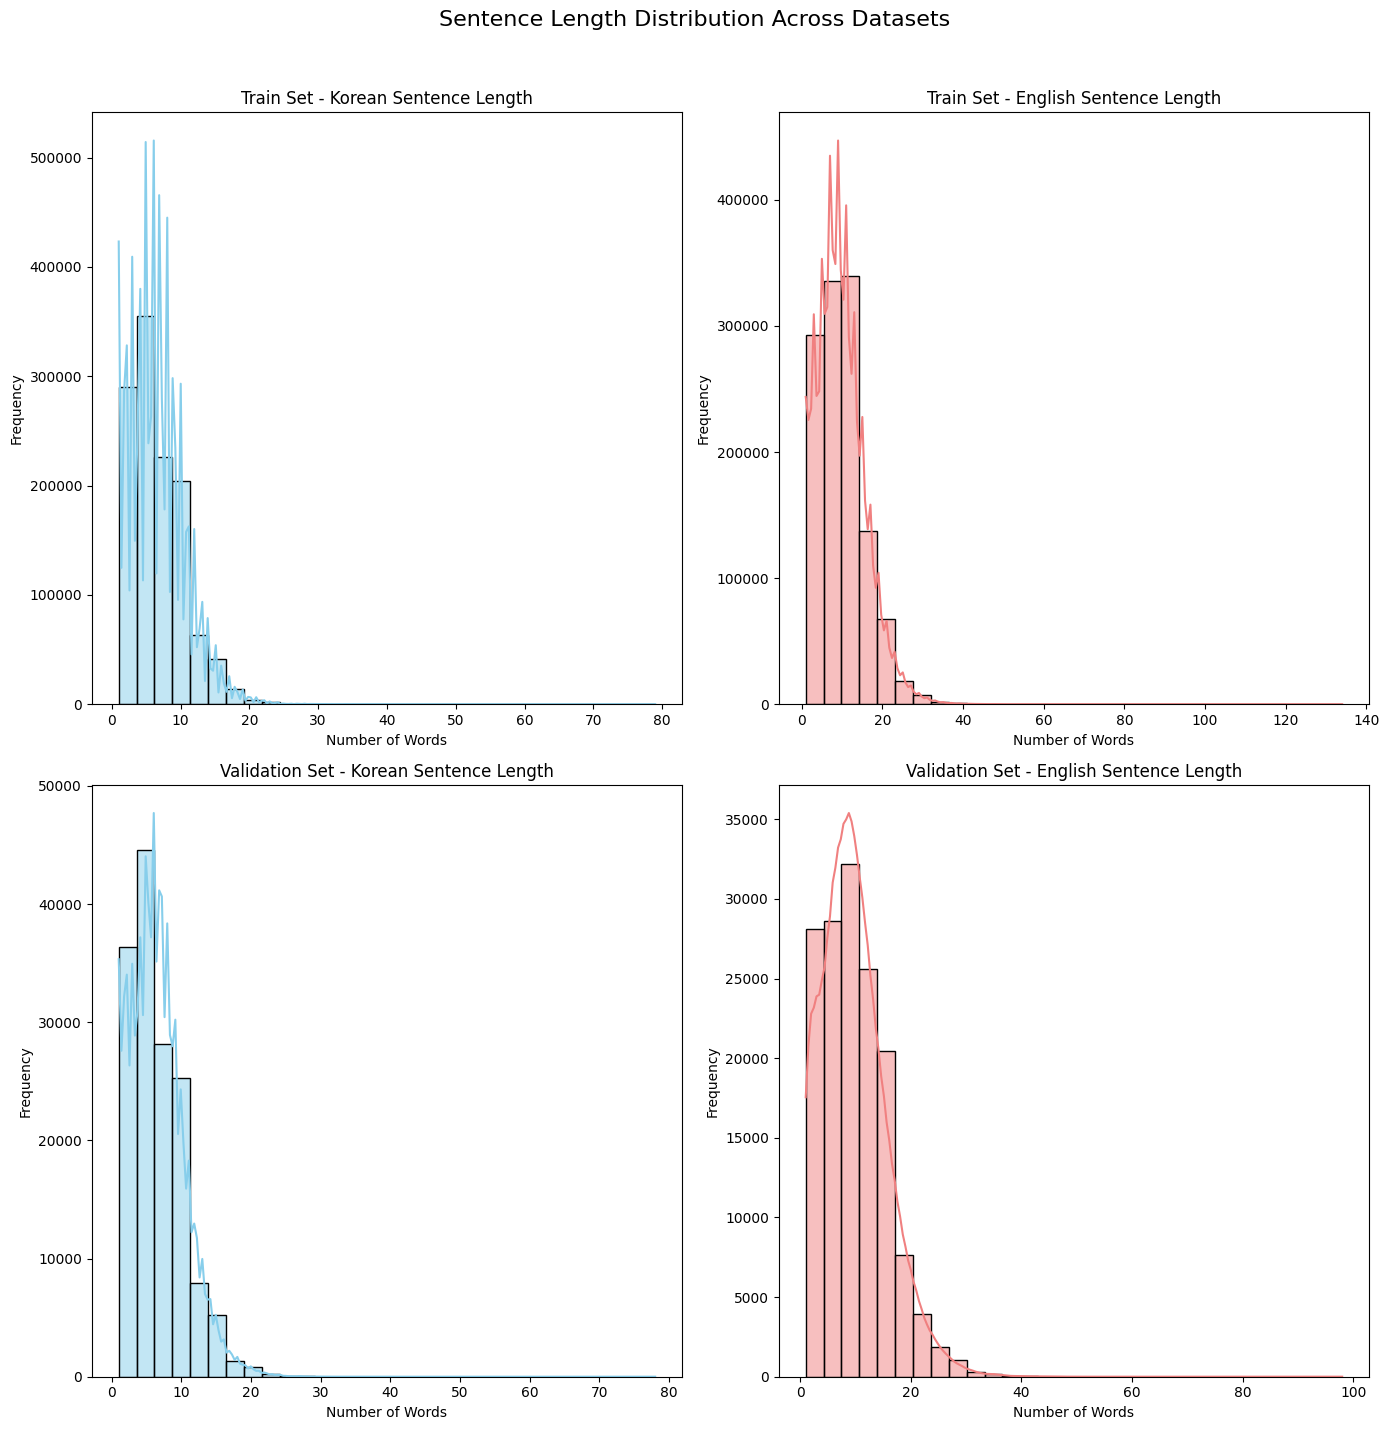

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 15))
fig.suptitle('Sentence Length Distribution Across Datasets', fontsize=16)

# Train Set - Korean
sns.histplot(df_train['ko_length'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Train Set - Korean Sentence Length')
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')

# Train Set - English
sns.histplot(df_train['en_length'], bins=30, kde=True, ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Train Set - English Sentence Length')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')

# Validation Set - Korean
sns.histplot(df_val['ko_length'], bins=30, kde=True, ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Validation Set - Korean Sentence Length')
axes[1, 0].set_xlabel('Number of Words')
axes[1, 0].set_ylabel('Frequency')

# Validation Set - English
sns.histplot(df_val['en_length'], bins=30, kde=True, ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_title('Validation Set - English Sentence Length')
axes[1, 1].set_xlabel('Number of Words')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [ ]:
# JSON 파일 경로
train_path = "/content/extracted_files/일상생활및구어체_한영_train_set.json"
valid_path = "/content/extracted_files/일상생활및구어체_한영_valid_set.json"
# JSON 파일 불러오기
def load_json(path, max_samples=1000):
  with open(path, 'r', encoding='utf-8') as f:
    data = json.load(f)
    print(f"{path}개수:{len(data['data'])}")
  return data["data"][:max_samples]
# 훈련, 검증 데이터 로드
data_train = load_json(train_path, max_samples=50000)
data_valid = load_json(valid_path, max_samples=1000)
# ko와 mt 데이터 추출
ko_train = [item['ko'] for item in data_train]
mt_train = [item['en'] for item in data_train]
ko_valid = [item['ko'] for item in data_valid]
mt_valid = [item['en'] for item in data_valid]

/content/extracted_files/일상생활및구어체_한영_train_set.json개수:1200000
/content/extracted_files/일상생활및구어체_한영_valid_set.json개수:150000


# Okt-한글,word_tokenize-영어

In [ ]:
# 한국어 및 영어 토크나이저
tokenizer_ko = Okt().morphs
tokenizer_en = word_tokenize

## 문장 길이 분석
ko_lengths = [len(tokenizer_ko(sent)) for sent in ko_train]
en_lengths = [len(tokenizer_en(sent)) for sent in mt_train]
all_lengths = ko_lengths + en_lengths

# 한국어와 영어 중 가장 긴 문장의 길이 기준으로 MAX_LENGTH 설정
MAX_LENGTH = max(max(ko_lengths), max(en_lengths)) + 1  # SOS, EOS 포함 고려
print(f"Max sequence length: {MAX_LENGTH}")

Max sequence length: 96


In [ ]:
# 특수 토큰 정의
SOS_token = 0 # 문장 시작
EOS_token = 1 # 문장 끝
PAD_token = 2 # 문장 길이를 맞추기 위해 채우는 빈칸
UNK_token = 3 # 사전에 없는 단어 (Unknown word)

# 단어장(vocab) 사전 만들기
class Lang:
    def __init__(self, name):
        self.name = name
        # 초기에는 PAD, SOS, EOS, UNK 토큰을 미리 등록
        self.word2index = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "<unk>"}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "<unk>"}
        self.word2count = {}
        self.n_words = 4  # PAD, SOS, EOS, UNK 포함

    def addSentence(self, sentence, tokenizer):
        for word in tokenizer(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1

# 데이터 준비
def prepareData(lang1, lang2, tokenizer1, tokenizer2):
    input_lang = Lang(lang1)# 한국어 사전
    output_lang = Lang(lang2)# 영어 사전
    pairs = list(zip(ko_train, mt_train)) # 문장 쌍 리스트
    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs:
        input_lang.addSentence(pair[0], tokenizer1)
        output_lang.addSentence(pair[1], tokenizer2)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData("ko", "en", tokenizer_ko, tokenizer_en)

# 텐서 변환 및 데이터 로더 생성
def tensorFromSentence(lang, sentence, tokenizer):
    indexes = [SOS_token]
    indexes += [lang.word2index.get(word, UNK_token) for word in tokenizer(sentence)[:MAX_LENGTH - 2]]
    indexes.append(EOS_token)
    # 길이 MAX_LENGTH에 맞춰 PAD 추가
    while len(indexes) < MAX_LENGTH:
        indexes.append(PAD_token)
    return torch.tensor(indexes[:MAX_LENGTH], dtype=torch.long, device=device)

def get_dataloader(batch_size):
    #모든 문장을 숫자 텐서로 변환
    input_tensors = [tensorFromSentence(input_lang, inp, tokenizer_ko) for inp, _ in pairs]
    target_tensors = [tensorFromSentence(output_lang, tgt, tokenizer_en) for _, tgt in pairs]
    #여러 문장을 하나의 큰 텐서로 합침
    input_tensors = torch.stack(input_tensors, dim=0)  # [num_samples, MAX_LENGTH]
    target_tensors = torch.stack(target_tensors, dim=0)  # [num_samples, MAX_LENGTH]

    # 입력(한국어)과 출력(영어)을 짝지어 데이터셋 객체 생성
    dataset = TensorDataset(input_tensors, target_tensors)
    # 학습할 때 문장 순서를 랜덤으로 섞음
    train_sampler = RandomSampler(dataset)
    # 데이터셋을 batch_size 단위로 잘라서 모델에 공급
    train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

    print(f"input_tensors.shape: {input_tensors.shape}, target_tensors.shape: {target_tensors.shape}")
    return train_dataloader
# 여러 문장을 묶어서 배치 단위로 모델에 공급
train_dataloader = get_dataloader(batch_size=32)

Read 50000 sentence pairs
input_tensors.shape: torch.Size([50000, 96]), target_tensors.shape: torch.Size([50000, 96])


In [ ]:
# 샘플 문장
print(ko_train[0])
print(mt_train[0])

원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.
If you reply to the color you want, we will start making it right away.


In [ ]:

# 검증 데이터를 위한 pair 생성
pairs_valid = list(zip(ko_valid, mt_valid))
print("Read %s validation sentence pairs" % len(pairs_valid))

Read 1000 validation sentence pairs


In [ ]:
#@title Seq2Seq
# import torch.nn.functional as F

# Encoder 정의
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

# Decoder 정의
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        # 초기 디코더 입력: SOS 토큰 ([batch_size, 1])
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=encoder_outputs.device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: target_tensor의 i번째 토큰 사용 ([batch_size, 1])
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # 모델 예측: topk 결과에서 가장 높은 확률을 가진 토큰 선택
                _, topi = decoder_output.topk(1)
                # topi의 shape: [batch_size, 1, 1] → squeeze 마지막 차원만 제거하여 [batch_size, 1]
                decoder_input = topi.squeeze(2).detach()

        # [batch_size, MAX_LENGTH, output_size]
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        # input: [batch_size, 1]
        output = self.embedding(input)          # → [batch_size, 1, hidden_size]
        output = F.relu(output)
        output, hidden = self.gru(output, hidden) # output: [batch_size, 1, hidden_size]
        output = self.out(output)                 # → [batch_size, 1, output_size]
        return output, hidden


In [ ]:

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion):
    encoder.train()
    decoder.train()

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        # 반드시 정수(LongTensor)로 변환
        input_tensor = input_tensor.long().to(device)
        target_tensor = target_tensor.long().to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def train_seq2seq(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100):
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        if epoch % print_every == 0:
            print(f"Epoch {epoch}/{n_epochs}, Loss: {loss:.4f}")


In [ ]:
# 모델 초기화 및 학습 실행
hidden_size = 128
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train_seq2seq(train_dataloader, encoder, decoder, n_epochs=30, print_every=1)


Epoch 1/30, Loss: 0.7931
Epoch 2/30, Loss: 0.5862
Epoch 3/30, Loss: 0.5371
Epoch 4/30, Loss: 0.5042
Epoch 5/30, Loss: 0.4778
Epoch 6/30, Loss: 0.4563
Epoch 7/30, Loss: 0.4374
Epoch 8/30, Loss: 0.4208
Epoch 9/30, Loss: 0.4060
Epoch 10/30, Loss: 0.3927
Epoch 11/30, Loss: 0.3808
Epoch 12/30, Loss: 0.3701
Epoch 13/30, Loss: 0.3603
Epoch 14/30, Loss: 0.3515
Epoch 15/30, Loss: 0.3434
Epoch 16/30, Loss: 0.3359
Epoch 17/30, Loss: 0.3290
Epoch 18/30, Loss: 0.3227
Epoch 19/30, Loss: 0.3168
Epoch 20/30, Loss: 0.3112
Epoch 21/30, Loss: 0.3062
Epoch 22/30, Loss: 0.3012
Epoch 23/30, Loss: 0.2968
Epoch 24/30, Loss: 0.2926
Epoch 25/30, Loss: 0.2885
Epoch 26/30, Loss: 0.2847
Epoch 27/30, Loss: 0.2810
Epoch 28/30, Loss: 0.2776
Epoch 29/30, Loss: 0.2743
Epoch 30/30, Loss: 0.2713


In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        # 단일 문장이므로 배치 차원 추가 (shape: [1, MAX_LENGTH])
        input_tensor = tensorFromSentence(input_lang, sentence, tokenizer_ko).unsqueeze(0)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])

        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)

        # <SOS>, <EOS>, SOS, EOS 등을 제거
        tokens_to_remove = ['<SOS>', 'SOS', '<EOS>', 'EOS']
        output_words = [w for w in output_words if w not in tokens_to_remove]

        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
evaluateRandomly(encoder, decoder)


> >멍게?
= >Sea squirts?
< > 130,000 won ?

> 저는 이거 다 체크를 해요.
= I check all of these.
< I 'm sorry .

> >애매한 답변을 하시네.
= >You're not giving us a clear answer.
< > You have to be thankful for himself .

> 미세날 세트, 소프트 보관 케이스, 충전 스탠드와 충전기, 부착형 가이드 빗, 청소용 브러시, 블레이드 오일 그리고 설명서가 포함되어 있습니다.
= Includes fine blade set, soft storage case, charging stand and charger, attachable guide comb, cleaning brush, blade oil and instruction manual.
< Includes lightweight mesh tongue and foam padded tongue and collar for perfect storage and a comfortable fit .

> 아이스크림 플라스틱 용기 500개를 사고 싶습니다.
= I'd like to buy 500 plastic containers of ice cream.
< I 'd like to buy a chiffon fabric for wholesale .

> >여기도 마찬가지, 반찬 싸가지고 가는 사람 있죠?
= >That must be same here, right?
< > What 's the name of the name tag ?

> 내일 모레 다시 연락드리겠습니다.
= I'll contact you again the day after tomorrow.
< I 'll contact you again tomorrow .

> 이를 통해 미리 계획을 세우고 주요 문제를 방지할 수 있습니다.
= This makes it possible to plan ahead and avoid major problems.
< 

In [ ]:
#@title Seq2Seq with Attention
# import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights


In [ ]:
# 모델 초기화 및 학습 실행
hidden_size = 128
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# 모델 학습 실행
train_seq2seq(train_dataloader, encoder, decoder, n_epochs=30, print_every=1)


Epoch 1/30, Loss: 0.7657
Epoch 2/30, Loss: 0.5798
Epoch 3/30, Loss: 0.5297
Epoch 4/30, Loss: 0.4903
Epoch 5/30, Loss: 0.4589
Epoch 6/30, Loss: 0.4330
Epoch 7/30, Loss: 0.4104
Epoch 8/30, Loss: 0.3906
Epoch 9/30, Loss: 0.3730


KeyboardInterrupt: 

In [ ]:
evaluateRandomly(encoder, decoder)

> 저희는 귀하께 시계 200개 주문했었습니다.
= We ordered 200 watches from you.
< We ordered 100 % of you .

> 궁금하신 모든 것들에 대해 답변해 드리겠습니다.
= I'll be the one to respond to all of your inquiries.
< I 'll be waiting for you to work with you .

> 일전 일본 지진시 귀사의 협조를 바탕으로 아이템 정보를 수집하여 큰 도움이 됐습니다.
= In the event of the Japanese earthquake the other day, it was very helpful by collecting item information based on your cooperation.
< I heard that you have to visit the information of the marketing department of the marketing department of your cooperation .

> 곧 들어온 새로운 직원들을 위해 주문한 책상과 의자 재발송이 시급합니다.
= It is urgent to resend the desks and chairs ordered for the new employees who came in soon.
< We are planning to have a meeting with the new product and the new marketing department .

> 제품의 다른 부분은 샘플을 써보니 매우 만족하고 있습니다.
= When I used the sample for other parts of the product, I was very satisfied.
< The product is very good , but I was very satisfied .

> 그러므로 그때까지는 자동 주차 기능을 사용하지 마십시오.
= Therefore, please do not use

In [ ]:
def evaluateRandomlyBleu(encoder, decoder, n=10):
    total_bleu_score = 0
    # SmoothingFunction을 사용하여 짧은 문장에서 BLEU 점수가 0이 되는 것을 방지
    sf = SmoothingFunction().method1

    for i in range(n):
        pair = random.choice(pairs)
        reference_ko, reference_en = pair[0], pair[1]

        print('>', reference_ko)
        print('=', reference_en)

        output_words, _ = evaluate(encoder, decoder, reference_ko, input_lang, output_lang)

        # <SOS>, <EOS>, SOS, EOS 등을 제거
        tokens_to_remove = ['<SOS>', 'SOS', '<EOS>', 'EOS']
        output_words = [w for w in output_words if w not in tokens_to_remove]

        output_sentence = ' '.join(output_words)
        print('<', output_sentence)

        # BLEU 스코어 계산
        # reference_tokenized는 토큰화된 참조 문장 리스트의 리스트여야 합니다 (여러 개의 참조 문장이 있을 수 있으므로).
        # 여기서는 하나의 참조 문장만 있으므로 [tokenizer_en(reference_en)] 형태로 전달합니다.
        reference_tokenized = [tokenizer_en(reference_en)]
        candidate_tokenized = output_words # 이미 단어 리스트 형태입니다.

        bleu = sentence_bleu(reference_tokenized, candidate_tokenized, smoothing_function=sf)
        print(f'BLEU: {bleu:.4f}')
        total_bleu_score += bleu
        print('')

    average_bleu = total_bleu_score / n
    print(f'Average BLEU score over {n} samples: {average_bleu:.4f}')
evaluateRandomlyBleu(encoder, decoder)

> >같이 살아야지.
= >We have to live together.
< > We 're ready to you .
BLEU: 0.0831

> 그래서 모든 종류의 멀티미디어 스피커 이동식 스토리지 LCD 및 플라즈마 TV까지 유통 제조 범위를 확장시켜가고 있습니다.
= Therefore, we are expanding our distribution manufacturing range to all kinds of multimedia speakers, portable storage LCDs, and plasma TVs.
< So , all the main ingredients for the world 's largest motor and sells various styles .
BLEU: 0.0108

> 저희 수면양말 제품은 샘플 신청이 가능합니다.
= You can apply for samples for our sleeping socks products.
< Our product can be shipped by our products .
BLEU: 0.0483

> 깊은 보습력으로 윤기 있는 모발을 가꿔주는 하이 다이브는 모발을 매끄럽고 촉촉하게 해 주며 곱슬거림을 제거하여 헤어 스타일을 유지해 줍니다.
= The high-dive, deep-moisturizing, lustrous hair keeps the hair smooth and supple, and removes frizz to keep the hair styled.
< The soft and forefinger the ultimate load is the most effective in the body and the skin barrier you to enjoy the water .
BLEU: 0.0129

> FFF에 대한 원자재 비용이 상승하였습니다.
= The cost of raw materials for FFF has risen.
< The price is made of the FFF 